# Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [93]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream: 
    if is_body:
        lines.append(line)
    elif line =='\n':
        is_body = True
stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [4]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [5]:
for i in generate_squares(3):
    print(i, end = ' -> ')

0 -> 1 -> 4 -> 

# Email Body Extraction

In [6]:
def email_body_generator(path): 
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
        
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream: 
                if is_body:
                    lines.append(line)
                elif line =='\n':
                    is_body = True
            stream.close()

            email_body = '\n'.join(lines)

            yield file_name, email_body

In [7]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)

In [8]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [9]:
spam_emails.shape

(1898, 2)

In [10]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00769.25bf9a767b5db0ed93f03c1637281663,"\n\nIn a message dated 9/24/2002 11:24:58 AM, ...",0
01074.8590d61ac0aeeadb58dc2f2ba776c406,"Hiya, I always seem to get errors when I do an...",0
02479.14365bcad3a60fcf24c5c1813f6291fb,\n\nI don't know how one can expect better and...,0
01417.ce7b07a2114218dbac682b599785820d,Tim Peters wrote:\n\n> I've run no experiments...,0
00357.d559b71616f64ba1d1c1e61a03644fd4,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr...",0


In [11]:
ham_emails.shape

(3901, 2)

In [12]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [13]:
data.tail()

,MESSAGE,CATEGORY
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0
00747.352d424267d36975a7b40b85ffd0885e,"If you run Pick, and then use the ""New FTOC"" b...",0


# Data Cleaning: Checking for Missing Values

In [14]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [15]:
# check if there are empty emails
(data.MESSAGE.str.len() == 0).any()

True

In [16]:
(data.MESSAGE.str.len() == 0).sum()

3

# Locate Empty Emails

In [17]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File Entries from Dataframe

In [18]:
data.drop(['cmds'], inplace=True)

In [19]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [20]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [21]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


In [22]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
5792,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,01127.841233b48eceb74a825417d8d918abf8
5794,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0,01178.5c977dff972cd6eef64d4173b90307f0
5795,"If you run Pick, and then use the ""New FTOC"" b...",0,00747.352d424267d36975a7b40b85ffd0885e


# Save to File using Pandas

In [23]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Charts)

In [24]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [25]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

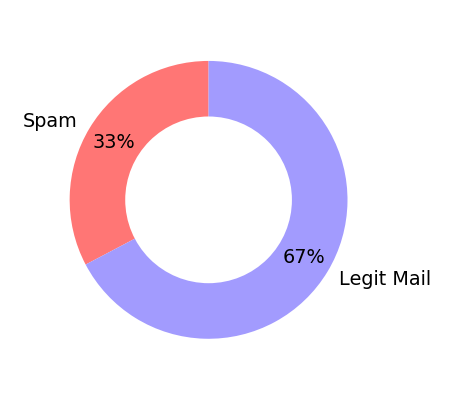

In [26]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675','#a29bfe']


plt.figure(figsize=(2,2), dpi = 230)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle = 90, autopct = '%1.0f%%', colors = custom_colors, pctdistance = 0.8)


#making a donut

centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Download the NLTK Resources (Tokenizer & Stopwords)

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vedantshrivastava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedantshrivastava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Functions for Email Processing

In [29]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # remove HTML tags
    
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower()) #converts to lower case and splits up individual words
    
    filtered_words = []
    
    for word in words:
        # removes stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    
    
    return filtered_words

In [30]:
clean_msg_no_html(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

# Apply Cleaning and Tokenization to all messages

## Slicing Dataframes and Series and Creating Subsets

In [31]:
%%time

#use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/Users/vedantshrivastava/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 29.1 s, sys: 57.6 ms, total: 29.2 s
Wall time: 29.2 s


In [32]:
nested_list.head()

DOC_ID
0    [dear, homeown, interest, rate, lowest, point,...
1    [attent, must, comput, user, packag, deal, nor...
2    [messag, mime, format, dare, tri, find, better...
3    [import, inform, new, domain, name, final, ava...
4    [bottom, line, give, away, cd, free, peopl, li...
Name: MESSAGE, dtype: object

In [33]:
nested_list.tail()

DOC_ID
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

## Using Logic to Slice Dataframes

In [34]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

## Subsetting a Series with an Index

In [35]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [36]:
nested_list_ham.shape

(3900,)

In [37]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [38]:
nested_list_spam.shape

(1896,)

In [39]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] #total number of unique words in the non-spam messages

20755

In [40]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [41]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] #total number of unique words in the spam messages

13284

In [42]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

# Word Cloud of Ham and Spam Messages

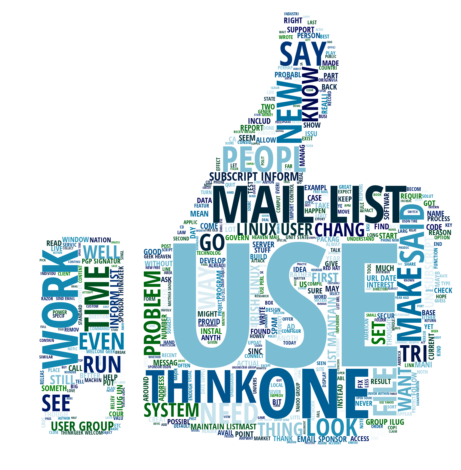

CPU times: user 12.8 s, sys: 1.99 s, total: 14.8 s
Wall time: 12.4 s


In [43]:
%%time

icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size = icon.size, color = (255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color = 'white', max_words = 500, colormap = 'ocean', max_font_size = 2000, font_path = CUSTOM_FONT_FILE)
word_cloud.generate(ham_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

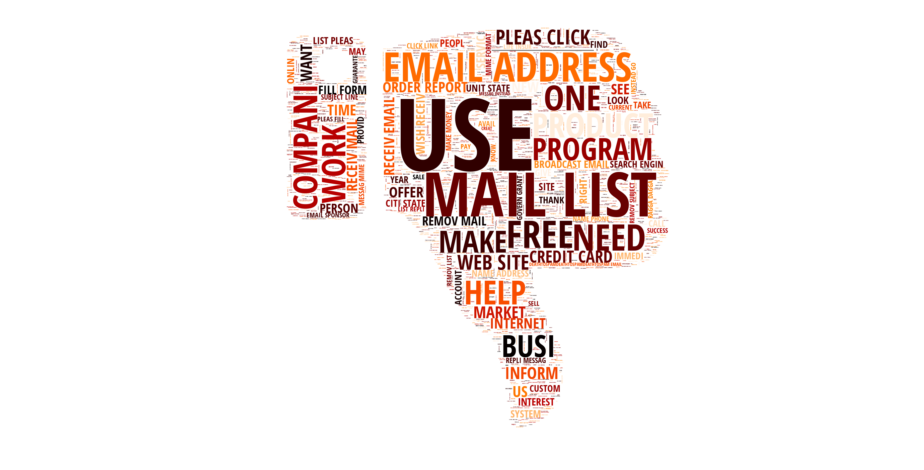

CPU times: user 44.1 s, sys: 12.6 s, total: 56.7 s
Wall time: 54.3 s


In [44]:
%%time

icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size = icon.size, color = (255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color = 'white', max_words = 2000, colormap = 'gist_heat', max_font_size = 300, font_path = CUSTOM_FONT_FILE)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [45]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [46]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])
unique_words.head()

Number of unique words 27305


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [47]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


# Create Vocabulary DataFrame with a WORD_ID

In [48]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


# Save the Vocabulary as a CSV File

In [49]:
vocab.to_csv(WORD_ID_FILE, index_label = vocab.index.name, header= vocab.VOCAB_WORD.name)

# Generate Features and a Sparse Matrix

## Creating a Dataframe with one word per column

In [50]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


In [51]:
word_columns_df.shape

(5796, 7671)

## Splitting the Data into Training and Testing Dataset

In [52]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size = 0.3, random_state = 42)

In [53]:
print('Number of training samples:', X_train.shape[0])
print('Fraction of training set:', X_train.shape[0]/word_columns_df.shape[0 ])

Number of training samples: 4057
Fraction of training set: 0.6999654934437544


In [54]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None


In [55]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Create a Sparse Matrix for the Training Data

In [56]:
word_index = pd.Index(vocab.VOCAB_WORD)
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [57]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 2min 5s, sys: 178 ms, total: 2min 5s
Wall time: 2min 5s


In [58]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,395
1,0,4844,1,494
2,0,4844,1,2402
3,0,4844,1,496
4,0,4844,1,37


In [59]:
sparse_train_df.shape

(445868, 4)

In [60]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
445863,1,860,1,126
445864,1,860,1,651
445865,1,860,1,518
445866,1,860,1,1394
445867,1,860,1,1078


# Combine Occurences with the Pandas groupby() Method

In [78]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       7       1              1
       15      1              1
       18      1              1
       24      1              1

In [77]:
vocab.at[0,'VOCAB_WORD']

'http'

In [79]:
train_grouped = train_grouped.reset_index()
train_grouped.head() 

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,7,1,1
2,0,15,1,1
3,0,18,1,1
4,0,24,1,1


In [80]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
265374,5795,1896,0,1
265375,5795,1908,0,2
265376,5795,2128,0,1
265377,5795,2300,0,1
265378,5795,2478,0,1


In [81]:
vocab.at[1908, 'VOCAB_WORD']

'welch'

In [82]:
data.MESSAGE[5795]

'If you run Pick, and then use the "New FTOC" button to show only\n\nthose messages selected by pick, then the ftoc display was considered\n\n"invalid" in the old code.  This prevented the display from being cached,\n\nand it meant that you could get back to the full folder display by\n\nclicking on the folder lablel.  That doesn\'t work anymore.  You have\n\nto resort to Rescan Folder.  In fact, when you change folders you\n\ncontinue to have the Pick results, not the new folder contents.\n\nIf you go to a any folder and do Rescan, then it heals itself.\n\n--\n\nBrent Welch\n\nSoftware Architect, Panasas Inc\n\nPioneering the World\'s Most Scalable and Agile Storage Network\n\nwww.panasas.com\n\nwelch@panasas.com\n\n\n\n\n\n\n\n\n\n_______________________________________________\n\nExmh-workers mailing list\n\nExmh-workers@redhat.com\n\nhttps://listman.redhat.com/mailman/listinfo/exmh-workers\n\n\n\n\n'

In [83]:
train_grouped.shape

(265379, 4)

# Save Training Data as .txt File

In [84]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [85]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Create a Sparse Matrix for the Test Data

In [86]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,could,tri,httrack,avail,http,recurs,grab,stuff,get,pictur,...,None,None,None,None,None,None,None,None,None,None
4220,adam,beberg,wrote,creator,didnt,say,could,without,pay,theft,...,None,None,None,None,None,None,None,None,None,None
2484,gari,lawrenc,murphi,wrote,say,hello,cool,oooo,go,caus,...,None,None,None,None,None,None,None,None,None,None
2418,wasnt,even,though,spellingi,oddli,familar,news,fork,randomis,letter,...,None,None,None,None,None,None,None,None,None,None
5110,gari,murphi,intend,take,legal,violent,action,peopl,world,away,...,None,None,None,None,None,None,None,None,None,None


In [87]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [88]:
X_test.shape

(1739, 7671)

In [89]:
%%time

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 55.4 s, sys: 196 ms, total: 55.6 s
Wall time: 55.6 s


In [90]:
sparse_test_df.shape

(188265, 4)

In [91]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,19,1,2
4,8,26,1,1


In [92]:
test_grouped.shape

(110495, 4)

In [94]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt = '%d')